In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../../..')))

In [2]:
# to store the PCE surrogate
import json

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom modules
import Surrogates.PolynomialChaosExpansion as PCE

from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import chaboche_uniform_isoprob_monotonic_transform
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations

# Model Evaluations

$\sigma(t; \, E, \sigma_{y|0}, Q_{iso}, b_{iso}, n_{iso}, D_{iso}, Q_{kin}, b_{kin} ;  \, \dot{\varepsilon}, \nu)$

## 8 Random Variables

($\nu$ if fixed to 0.3)

1. Young's Modulus: $E$

2. Initial Yield Limit: $\sigma_{y|0}$

### Isotropic Parameters

3. Isotropic Asympotote: $Q_{iso}$

4. Isotropic growth rate: $b_{iso}$

5. Isotrpic exponent: $n_{iso}$

6. Isotropic threshold: $D_{iso}$

### Kinematic Parameters

7. Kinematic Asympotote: $Q_{kin}$

8. Kinematic growth rate: $b_{kin}$



In [6]:
number_of_realizations = 5_000

t_min = 0
t_max = 2
delta_t = 1e-3 # time step
n_t = int((t_max-t_min)/delta_t)

t_linspace = np.linspace(t_min, t_max, n_t+1)

max_strain = 5e-2
time_to_max_strain = 1

model = ChabocheModel('1D', 'monotonic', max_strain, time_to_max_strain)

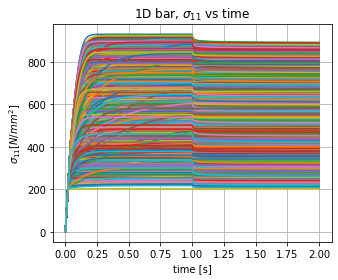

In [4]:
# store samples of parameters
# each row contains 1 set of parameters
SampleSpace = chaboche_samples(number_of_realizations) # [number_of_realizations, 8] matrix

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace[:, 6] = 0 # set Q_kin to 0
SampleSpace[:, 7] = 0 # set b_kin to 0

func_evaluations = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace, parallel_computation = True)

# plot solution corresponding to each set of random variable
model.stress_plot(t_min, t_max, delta_t, func_evaluations)

In [15]:
I = np.array([0, 2.5, 5, 7.5, 10]) / delta_t # index
I = I.astype(int)

print(I)

[    0  2500  5000  7500 10000]


In [ ]:
# PCE Surrogate
total_polynomial_degree = 5
number_of_random_variables = N_p = 6
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, chaboche_uniform_isoprob_monotonic_transform)

# Points where PCE surrogates must be computed
I = np.linspace(5*delta_t, 2, 5+1) / delta_t # index
I = I.astype(int)
num_of_surrogates = len(I)
T = np.linspace(0, 2, n_t+1)

# store beta
# betas stored column-wise
store_beta = np.zeros((PCE_t_i.number_of_PCE_terms, num_of_surrogates))

# store LOO error
LOO_error = np.zeros((num_of_surrogates, 1))

# store variance
store_variance = np.zeros((num_of_surrogates, 1))

print(f"Number of PCE terms: {PCE_t_i.number_of_PCE_terms}")
print(f"Number of evaluations needed (empirical estimate): {(number_of_random_variables - 1)*PCE_t_i.number_of_PCE_terms}") # (M-1)*P [Sudret]
print(f"Number of function evaluations: {func_evaluations.shape[1]}") 

for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

    X_hat = SampleSpace[:, :6]
    Y_hat = func_evaluations[time_index, :]

    store_beta[:, j] = PCE_t_i.find_coefficients(X_hat, Y_hat)

    # store error at each t_i
    LOO_error[j] = PCE_t_i.LeaveOneOut(X_hat, Y_hat)

    # store variance at each t_i
    product_beta = store_beta[:, j]**2
    store_variance[j] = np.sum(product_beta[1:])

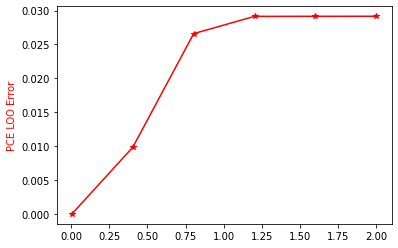

In [26]:
fig, ax = plt.subplots()

ax.plot(T[I], LOO_error,  '-*', color = 'red', label = 'PCE LOO Error')
ax.set_ylabel("PCE LOO Error", color = 'red')

plt.show()

# Error in Variance

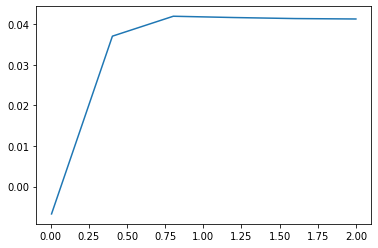

In [27]:
# plt.plot(T, np.var(func_evaluations, axis=1)
vals = np.var(func_evaluations, axis=1)

error = (vals[I] - store_variance.T) / vals[I]

plt.plot(T[I], error.T)

plt.show()

In [ ]:
SURROGATE_INFO = {
                'total_polynomial_order': total_polynomial_degree,
                'polynomial_classes_of_random_variables':['Legendre']*number_of_random_variables,
                'store_beta':store_beta.tolist(),
                }

with open('PCE_chaboche_monotonic_strainrate_1.json', 'w') as f:
        json.dump(SURROGATE_INFO, f)

In [3]:
with open('PCE_chaboche_monotonic_strainrate_1.json', 'r') as f:
    trained_model_data = json.load(f)

In [4]:
PCE_chaboche_monotonic_surrogate = PCE.PCE_surrogate_evaluate(trained_model_data, chaboche_uniform_isoprob_monotonic_transform)

In [12]:
np.array(trained_model_data['store_beta']).shape

(924, 1)

In [7]:
SampleSpace_test = chaboche_samples(1_00)

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace_test[:, 6] = 0 # set Q_kin to 0
SampleSpace_test[:, 7] = 0 # set b_kin to 0

# True model evaluations
Y_test = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace_test, parallel_computation = True)

index_Y_test = Y_test[10, :].reshape((-1,1))

# Surrogate model evaluations
Y_surrogate = PCE_chaboche_monotonic_surrogate.surrogate_evaluate(SampleSpace_test[:, :6])

# Relative error 
print(f"Relative L2 Error: {(np.linalg.norm(Y_surrogate - index_Y_test)*100/np.linalg.norm(index_Y_test)):.5f}%")

# Variance Error
print(f"Relative Variance Error: {((np.var(Y_surrogate) - np.var(index_Y_test))*100/np.var(index_Y_test)):.5f}%")

Relative L2 Error: 0.00000%
Relative Variance Error: 0.00000%
